# Main imports and code

In [1]:
#!pip install matplotlib --upgrade
import matplotlib
matplotlib. __version__

'3.5.1'

In [2]:
# check which gpu we're using
!nvidia-smi

Wed Mar  2 00:07:14 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install simpletransformers
!pip install tensorboardx

     |████████████████████████████████| 248 kB 5.1 MB/s 
     |████████████████████████████████| 3.5 MB 70.7 MB/s 
     |████████████████████████████████| 1.7 MB 44.9 MB/s 
     |████████████████████████████████| 9.7 MB 59.2 MB/s 
     |████████████████████████████████| 311 kB 71.1 MB/s 
     |████████████████████████████████| 6.5 MB 52.1 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 1.2 MB 45.9 MB/s 
     |████████████████████████████████| 895 kB 55.1 MB/s 
     |████████████████████████████████| 67 kB 6.6 MB/s 
     |████████████████████████████████| 596 kB 66.0 MB/s 
     |████████████████████████████████| 144 kB 72.3 MB/s 
     |████████████████████████████████| 181 kB 58.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
     |████████████████████████████████| 212 kB 65.9 MB/s 
     |████████████████████████████████| 134 kB 70.1 MB/s 
     |████████████████████████████████| 1.1 MB 59.3 MB/s 
     |███████████████

     |████████████████████████████████| 125 kB 5.3 MB/s 


In [4]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs, MultiLabelClassificationModel, MultiLabelClassificationArgs
from urllib import request
import pandas as pd
import logging
import torch
from collections import Counter
from ast import literal_eval

In [5]:
# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# check gpu
cuda_available = torch.cuda.is_available()

print('Cuda available? ',cuda_available)

Cuda available?  True


In [6]:
if cuda_available:
  import tensorflow as tf
  # Get the GPU device name.
  device_name = tf.test.gpu_device_name()
  # The device name should look like the following:
  if device_name == '/device:GPU:0':
      print('Found GPU at: {}'.format(device_name))
  else:
      raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


# Fetch Don't Patronize Me! data manager module

In [7]:
module_url = f"https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py"
module_name = module_url.split('/')[-1]
print(f'Fetching {module_url}')
#with open("file_1.txt") as f1, open("file_2.txt") as f2
with request.urlopen(module_url) as f, open(module_name,'w') as outf:
  a = f.read()
  outf.write(a.decode('utf-8'))

Fetching https://raw.githubusercontent.com/Perez-AlmendrosC/dontpatronizeme/master/semeval-2022/dont_patronize_me.py


In [8]:
# helper function to save predictions to an output file
def labels2file(p, outf_path):
	with open(outf_path,'w') as outf:
		for pi in p:
			outf.write(','.join([str(k) for k in pi])+'\n')

In [9]:
from dont_patronize_me import DontPatronizeMe

In [10]:
dpm = DontPatronizeMe('.', '.')

In [11]:
dpm.load_task1()
dpm.load_task2(return_one_hot=True)

Map of label to numerical label:
{'Unbalanced_power_relations': 0, 'Shallow_solution': 1, 'Presupposition': 2, 'Authority_voice': 3, 'Metaphors': 4, 'Compassion': 5, 'The_poorer_the_merrier': 6}


# Load paragraph IDs

In [12]:
trids = pd.read_csv('train_semeval_parids-labels.csv')
teids = pd.read_csv('dev_semeval_parids-labels.csv')

In [13]:
trids.head()

,par_id,label
0,4341,"[1, 0, 0, 1, 0, 0, 0]"
1,4136,"[0, 1, 0, 0, 0, 0, 0]"
2,10352,"[1, 0, 0, 0, 0, 1, 0]"
3,8279,"[0, 0, 0, 1, 0, 0, 0]"
4,1164,"[1, 0, 0, 1, 1, 1, 0]"


In [14]:
trids.par_id = trids.par_id.astype(str)
teids.par_id = teids.par_id.astype(str)



# Rebuild training set (Task 1)

In [15]:
rows = [] # will contain par_id, label and text
for idx in range(len(trids)):  
  parid = trids.par_id[idx]
  #print(parid)
  # select row from original dataset to retrieve `text` and binary label
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [16]:
trdf1 = pd.DataFrame(rows)

# Rebuild test set (Task 1)

In [17]:
rows = [] # will contain par_id, label and text
for idx in range(len(teids)):  
  parid = teids.par_id[idx]
  #print(parid)
  # select row from original dataset
  text = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].text.values[0]
  label = dpm.train_task1_df.loc[dpm.train_task1_df.par_id == parid].label.values[0]
  rows.append({
      'par_id':parid,
      'text':text,
      'label':label
  })
  

In [18]:
len(rows)

2094

In [19]:
tedf1 = pd.DataFrame(rows)

# Data Analysis


In [20]:
data_all = dpm.train_task1_df.copy()

In [66]:
def len_list(len):
  
  if len > 60:
    return ">60"
  elif len <=60 and len>42:
    return "42-60"
  elif len <=42 and len>30:
    return '30-42'
  else:
    return "<=30"


In [67]:
import math
data_all['len'] = data_all.apply (lambda row: (int(len(row['text'].split()))), axis=1)
# drop zero length text
data_all = data_all.drop(data_all.index[data_all.len ==0])
# log length
data_all['log_len'] = data_all.apply (lambda row: math.log(int(len(row['text'].split()))), axis=1)

data_all['text_len'] = data_all.apply (lambda row: len_list(row.len), axis=1)


In [68]:
data_train = pd.merge(data_all,trids[['par_id']],on='par_id', how='right')

<AxesSubplot:xlabel='label', ylabel='log_len'>

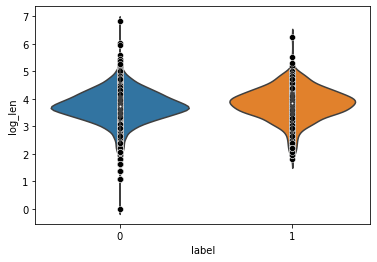

In [69]:
# import the seaborn library
import seaborn as sns


sns.violinplot(x ='label', y ='log_len', data = data_train)
sns.scatterplot(x ='label', y ='log_len', data = data_train, color ='black')


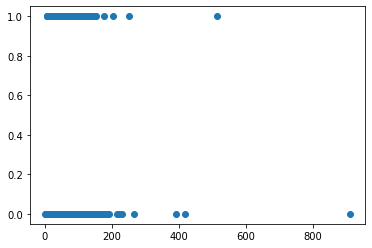

In [70]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
txt = []
lbl = []
for index, row in data_train.iterrows():
  txt.append(len(row['text'].split()))
  lbl.append(row['label'])
matplotlib.pyplot.scatter(txt, lbl)

In [71]:
# analysis text mean and median
np.median(txt) # 42
np.mean(txt) # 48.6
np.var(txt)
np.percentile(txt, (25,50,75))

array([30., 42., 60.])

In [77]:
#len(txt) # 8375 # since mean = 48, split into 4 parts (0-25, 26-50, 51-100,101+)
def text_list(txt, split_list):
  txt_list = []
  len_list = []
  for i, num in enumerate(split_list):

    if i == 0:
      txtg = np.array(txt) <= num
      leng = len(np.array(txt)[txtg])
    else:
      txtg = np.where((np.array(txt) > split_list[i-1]) & (np.array(txt) <= num))
      leng = len(np.array(txt)[txtg])
    txt_list.append(txtg)
    len_list.append(leng)

  txtg =  np.where(np.array(txt) > num)
  leng = len(np.array(txt)[txtg])
  txt_list.append(txtg)
  len_list.append(leng)    

  return txt_list, len_list

txt_list, len_list = text_list(txt, [30, 42, 60])


In [78]:
def zero_and_one(lbl, txt_list):
  x_1_list = []
  x_0_list = []
  for i in range(len(txt_list)):

    x_1 = sum(np.array(lbl)[txt_list[i]])
    x_0 = len(np.array(lbl)[txt_list[i]]) - x_1
    x_1_list.append(x_1)
    x_0_list.append(x_0)
  return x_1_list, x_0_list


x_1_list, x_0_list = zero_and_one(lbl, txt_list)

In [79]:
pre_0_list = []
pre_1_list = []
for i in range(len(x_1_list)):
  pre_0 = x_0_list[i]/(x_1_list[i] + x_0_list[i])
  pre_1 = 1- pre_0
  pre_1_list.append(pre_1)
  pre_0_list.append(pre_0)



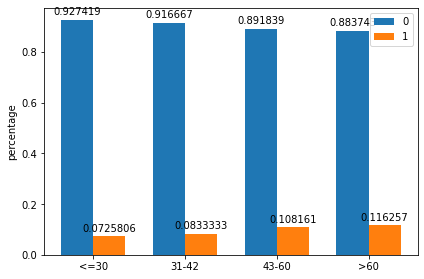

In [81]:
import matplotlib.pyplot as plt
import numpy as np


labels = ['<=30', '31-42', '43-60', '>60']

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, pre_0_list, width, label='0')
rects2 = ax.bar(x + width/2, pre_1_list, width, label='1')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('percentage')
#ax.set_title('percentage of class labels with different input length')
ax.set_xticks(x, labels)
ax.legend()

ax.bar_label(rects1, padding=3)
ax.bar_label(rects2, padding=3)

fig.tight_layout()

plt.show()

In [82]:
# import module
from tabulate import tabulate
 
# assign data
mydata = [
    ["Number of class labels",str(sum(x_0_list)), str(sum(x_1_list))],
    ["Proportion of class labels",'{:.2%}'.format((sum(x_0_list)/(sum(x_0_list)+sum(x_1_list)))), 
     '{:.2%}'.format(sum(x_1_list)/(sum(x_0_list)+sum(x_1_list)))]]
 
# create header
head = [" ","0", "1"]
 
# display table
print(tabulate(mydata, headers=head, tablefmt="grid"))

+----------------------------+--------+-------+
|                            | 0      | 1     |
+============================+========+=======+
| Number of class labels     | 7581   | 794   |
+----------------------------+--------+-------+
| Proportion of class labels | 90.52% | 9.48% |
+----------------------------+--------+-------+


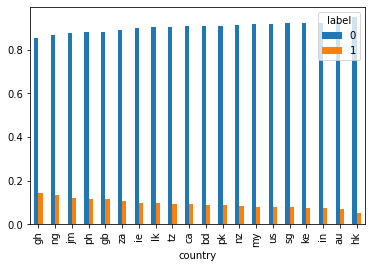

In [83]:
# country features
data_country = data_train.groupby(['country','label'])['art_id'].count()

#data_country.unstack()
data_country_p = data_country.groupby(level=0).apply(lambda x:
                                                 x / float(x.sum()))
data_country_p = data_country_p.unstack()
data_country_p = data_country_p.sort_values(by=[1],ascending=False)

data_country_p.plot(kind='bar')
plt.show()

In [84]:
data_country_p

label,0,1
country,,
gh,0.856492,0.143508
ng,0.867133,0.132867
jm,0.878238,0.121762
ph,0.881818,0.118182
gb,0.883777,0.116223
za,0.892938,0.107062
ie,0.901176,0.098824
lk,0.904535,0.095465
tz,0.906542,0.093458


In [85]:
# keywords features
data_key = data_train.groupby(['keyword','label'])['art_id'].count()
data_key

keyword        label
disabled       0        767
               1         67
homeless       0        716
               1        149
hopeless       0        690
               1         98
immigrant      0        820
               1         23
in-need        0        713
               1        143
migrant        0        851
               1         31
poor-families  0        607
               1        112
refugee        0        807
               1         73
vulnerable     0        811
               1         60
women          0        799
               1         38
Name: art_id, dtype: int64

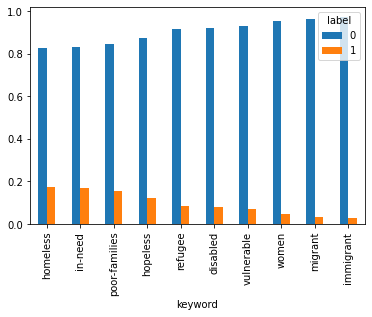

In [86]:
data_key_p = data_key.groupby(level=0).apply(lambda x:
                                                 x / float(x.sum()))
data_key_p = data_key_p.unstack()
data_key_p = data_key_p.sort_values(by=[1],ascending=False)

data_key_p.plot(kind='bar')
plt.show()

In [87]:
data_key_p

label,0,1
keyword,,
homeless,0.827746,0.172254
in-need,0.832944,0.167056
poor-families,0.844228,0.155772
hopeless,0.875635,0.124365
refugee,0.917045,0.082955
disabled,0.919664,0.080336
vulnerable,0.931114,0.068886
women,0.954600,0.045400
migrant,0.964853,0.035147


In [88]:
# label 1,2,3,4 proportion
data_label = data_train.groupby(['orig_label'])['art_id'].count()

#data_label_p = data_label.apply(lambda x:  x / float(x.sum()))

data_label


orig_label
0    6825
1     756
2     126
3     369
4     299
Name: art_id, dtype: int64

# Metric Analysis

##3.1 

In [56]:
# import predict result
preds_task1 = pd.read_csv('dev_predictions.txt', sep=" ", header=None)
preds_task1.columns=["predict_label"]

In [57]:
# data merge
tedf1.set_index('par_id')
data_all.set_index('par_id')
merged_data = pd.merge(tedf1,dpm.train_task1_df[['par_id','orig_label']],on='par_id', how='left')

In [58]:
merged_data

,par_id,text,label,orig_label
0,4046,We also know that they can benefit by receivin...,1,3
1,1279,Pope Francis washed and kissed the feet of Mus...,1,4
2,8330,Many refugees do n't want to be resettled anyw...,1,2
3,4063,"""Budding chefs , like """" Fred """" , """" Winston ...",1,4
4,4089,"""In a 90-degree view of his constituency , one...",1,3
...,...,...,...,...
2089,10462,"The sad spectacle , which occurred on Saturday...",0,0
2090,10463,""""""" The Pakistani police came to our house and...",0,0
2091,10464,"""When Marie O'Donoghue went looking for a spec...",0,0
2092,10465,"""Sri Lankan norms and culture inhibit women fr...",0,1


In [59]:
def metric_m(row):
  label = row['label']
  p_label = row['predict_label']
  if label ==1 and p_label ==1 :
    return 'TP'
  elif label == 1 and p_label == 0:
    return 'FN'
  elif label == 0 and p_label == 0:
    return 'TN'
  else:
    return 'FP'

In [60]:

def merge_high(testset, label_pred):
  """
  input:
  testset: dataframe with column 'par_id' and 'orig_label'
  label_pred: dataframe with column 'par_id' and 'predicted_label'

  output: dataframe with column metrics and ratio(True/(True+Flase))
                         row the true high level 'label' from 0 to 4
  """

  #out = pd.DataFrame(data=label_pred, columns=["predict_label"])
  out = label_pred
  merge_data = pd.concat([testset, out],axis = 1).reindex(testset.index)
  merge_data['metric'] = merge_data.apply (lambda row: metric_m(row), axis=1)
  merge_data_group = merge_data.groupby(['orig_label','metric'])['metric'].count()
  merge_data_group_p = merge_data_group.unstack()
  merge_data_group_p['ratio'] = merge_data_group_p.apply (lambda row: get_ratio(row), axis=1)
  return merge_data_group_p


In [61]:
from pandas.core.arrays.numeric import T
index = -1

def map(i):
  if i<2:
    return 0
  else:
    return 1

def find_denominator(i):
    if i<2:
      return 'TN'
    else:
      return 'TP'

def get_ratio(row):
  global index
  index = index+1
  return row[find_denominator(index)]/row.sum()

# call function
################################
# input: test_data + predict_data
m1 = merge_high(merged_data, preds_task1)
m1

metric,FN,FP,TN,TP,ratio
orig_label,,,,,
0,NaN,94.0,1610.0,NaN,0.944836
1,NaN,44.0,147.0,NaN,0.769634
2,14.0,NaN,NaN,4.0,0.222222
3,43.0,NaN,NaN,46.0,0.516854
4,26.0,NaN,NaN,66.0,0.717391


##3.2

In [89]:
# data merge( add len and log_len)
tedf1.set_index('par_id')
data_all.set_index('par_id')
merged_data_len = pd.merge(tedf1,data_all[['par_id','len','log_len','text_len']],on='par_id', how='left')

In [90]:
from pandas.core.arrays.numeric import T

def merge_len(testset, label_pred):
  """
  input:
  testset: dataframe with column 'par_id' ,'label' and 'orig_label'
  pred: ndarray or dataframe with column 'par_id' and 'predicted_label'

  output: dataframe with column: metric,
                         row: length of text
  """

  out = pd.DataFrame(data=label_pred, columns=["predict_label"])
  merge_data = pd.concat([testset, out],axis = 1).reindex(testset.index)
  merge_data['metric'] = merge_data.apply (lambda row: metric_m(row), axis=1)
  merge_data_group = merge_data.groupby(['text_len','metric'])['metric'].count()
  m2 = merge_data_group.unstack()
  m2['precision'] = m2.TP /(m2.TP+m2.FP)
  m2['recall'] = m2.TP /(m2.TP+m2.FN)
  m2['f1'] = 2 * (m2.precision * m2.recall) / (m2.precision + m2.recall)  
  return m2

In [91]:
# call function
################################
# input: test_data + predict_data
m2 = merge_len(merged_data_len, preds_task1)
m2.sort_values(by=['f1'])# sort

metric,FN,FP,TN,TP,precision,recall,f1
text_len,,,,,,,
>60,35,37,377,32,0.463768,0.477612,0.470588
<=30,9,42,481,28,0.400000,0.756757,0.523364
30-42,22,31,443,30,0.491803,0.576923,0.530973
42-60,17,28,455,26,0.481481,0.604651,0.536082
